In [3]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

learning_rate = 0.001
batch_size = 256
h = 128
z_size = 100
x_size = 784
x1_size = 10

#read data
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

def fullLayer(input_data, output_size, act, name, std = 0.1):
    w = tf.Variable(tf.random_normal([input_data.get_shape().as_list()[1], output_size], stddev = std, name = name + "_weigth"))
    b = tf.Variable(tf.zeros([output_size]), name = name + "_bias")
    return act(tf.matmul(input_data, w) + b)

x = tf.placeholder(tf.float32, [None, x_size], name='x')


with tf.variable_scope("encoder"):
    enc_hidden = fullLayer(x, h, act = tf.nn.relu ,name = "enc_hidden")
    enc_mu = fullLayer(enc_hidden, z_size, act = tf.identity , name = "enc_mu")
    enc_sigma = fullLayer(enc_hidden, z_size, act = tf.exp, name = "enc_sigma")
    
with tf.variable_scope("sampling"):
    eps = tf.Variable(tf.random_normal([z_size]))
    z = eps * enc_sigma + enc_mu

with tf.variable_scope("decoder"):
    dec_hidden = fullLayer(z, h, act = tf.nn.relu,name = "dec_hidden")
    dec_mu = fullLayer(dec_hidden, x_size, act = tf.nn.sigmoid, name = "dec_mu")
    dec_sigma = fullLayer(dec_hidden, x_size, act = tf.nn.sigmoid, name = "dec_sigma")

with tf.variable_scope("vae_loss"):
    ent_loss = -tf.reduce_sum(x * tf.log(1e-10 + dec_mu) + (1-x) * tf.log(1e-10 + 1 - dec_mu), axis = 1)
    kl_loss = -0.5 * tf.reduce_sum(1 + 2 * tf.log(enc_sigma) - tf.square(enc_mu) - enc_sigma * enc_sigma, axis = 1)
    print(ent_loss.shape)
    print(kl_loss.shape)
    loss = tf.reduce_mean(ent_loss + kl_loss)

with tf.variable_scope("optimizer_init"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    init = tf.global_variables_initializer()

Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz
(?,)
(?,)


In [4]:
import time

n_epochs = 100

#just some config for not getting whole server
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(gpu_options=gpu_options)

sess = tf.Session(config = config)
##starting time
start_time = time.time()
##initialize the variables
sess.run(init)

## number of training batches
n_batches = int(mnist.train.num_examples / batch_size)

for i in range(n_epochs):  # train the model n_epochs times
    total_loss = 0
    total_acc = 0
    for _ in range(n_batches):
        ##training batches
        x_batch, _ = mnist.train.next_batch(batch_size)
        _, loss_batch = sess.run([optimizer, loss], feed_dict={x: x_batch})
        total_loss += loss_batch

    print('epoch {}, Average loss : {}'.format(i, total_loss / n_batches))

print('Total time: {0} seconds'.format(time.time() - start_time))
print('Optimization Finished!')



epoch 0, Average loss : 214.51158441561404
epoch 1, Average loss : 138.12789617520627
epoch 2, Average loss : 127.21982627939956
epoch 3, Average loss : 122.55990119292358
epoch 4, Average loss : 119.29770089978369
epoch 5, Average loss : 116.94518190900857
epoch 6, Average loss : 115.19246520283066
epoch 7, Average loss : 113.93639740988473
epoch 8, Average loss : 112.69988008303064
epoch 9, Average loss : 111.81983858625466
epoch 10, Average loss : 111.05031204223633
epoch 11, Average loss : 110.28471574159425
epoch 12, Average loss : 109.55141937398464
epoch 13, Average loss : 108.89553964917904
epoch 14, Average loss : 108.35513893911772
epoch 15, Average loss : 107.59270958588502
epoch 16, Average loss : 107.20773679073726
epoch 17, Average loss : 106.69194184062637
epoch 18, Average loss : 106.23466074578116
epoch 19, Average loss : 105.67447972520489
epoch 20, Average loss : 105.29811688004253
epoch 21, Average loss : 105.046061292987
epoch 22, Average loss : 104.55350530036142


In [5]:
def to_one_hat(x):
    out = np.zeros((len(x), 10))
    for i, a in enumerate(x):
        out[i, a] = 1
    return out

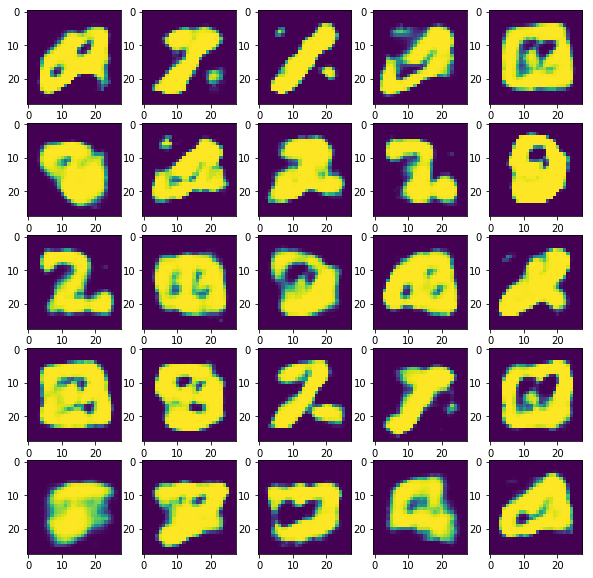

In [6]:
import matplotlib.pyplot as plt
mean = np.zeros(z_size)
cov = np.eye(z_size)
z1 = np.random.multivariate_normal(mean, cov, 25)
d_mu, d_sigma = sess.run([dec_mu, dec_sigma],feed_dict={z:z1})

fig, axes = plt.subplots(5, 5, figsize = (10,10))
for i, im in enumerate(d_mu):
    axes[i // 5, i % 5].imshow(im.reshape(28,28))
plt.show()